Creates spatial library of WindNinja simulations at 240m that match the NARR 32km grid dimensions

W. Matt Jolly, USFS, RMRS, Missoula Fire Sciences Laboratory
25 Sept 2024

In [2]:
import ipyparallel as ipp
import requests,os,math, rioxarray, timeit
import xarray as xr
import numpy as np
from osgeo import gdal
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from Download import *
import contextily as cx
from rioxarray.merge import merge_arrays
import utm

In [3]:
#!pip install utm

### Required files


In [4]:
#narropath = 'E:/Data/NARR/Data/'
bndryfile = 'WindNinjaData/ne_10m_admin_1_states_provinces_lakes.shp'  # From Natural Earth
WindNinja_cli = 'C:/WindNinja/WindNinja-3.11.0/bin/WindNinja_cli.exe'  # Installed as part of WindNinja desktop
conus_dem_file = 'WindNinjaData/LC20_Elev_220_RS_240m.tif'             # Resamples from the LANDFIRE 2020 DEM
# NARR files for examples and the final NARR grid as a shapefile
narr_full_grid = 'WindNinjaData/narr_full_grid.tif'
narr_mask = 'WindNinjaData/narr_mask_new.tif'
narr_mask_shp = 'WindNinjaData/narr_mask.shp'
## This is where all the outputs will be written
basedir = 'E:/Data/WindNinja/CONUS/'                                   # Set this to anything, must create the parent directory (CONUS in this example)

In [5]:
# Function" MakeAndCallWindNinjaCLICmd
# Purpose: Form the command for a call to the WindNinja CLI and spawn a system call to it
# Inputs:
## This is an example args dictionary: args = {'input_speed' : 5, 'input_direction' : 0, 'elevation_file' : dempath, 'WindNinja_cli':WindNinja_cli}
## Note: Lots of parameters are fixed inside this function 
def MakeAndCallWindNinjaCLICmd(args):
    import os
    from osgeo import gdal
    WindNinja_cli = args['WindNinja_cli']
    initialization_method = "domainAverageInitialization"
    output_wind_height = 10
    units_output_wind_height = 'm'
    elevation_file = args['elevation_file']
    input_speed = args['input_speed'] 
    input_direction = args['input_direction']
    input_speed_units = 'mph'  
    input_wind_height = 10 
    units_input_wind_height = 'm' 
    vegetation = 'grass' 
    mesh_resolution = 240 
    units_mesh_resolution = 'm' 
    write_ascii_output = 1 
    num_threads = 1
    cmd = f'{WindNinja_cli} --elevation_file {elevation_file} --initialization_method {initialization_method} --output_wind_height {output_wind_height}\
        --units_output_wind_height {units_output_wind_height} --input_speed {input_speed} --input_speed_units {input_speed_units} --input_direction {input_direction}\
        --input_wind_height {input_wind_height} --units_input_wind_height {units_input_wind_height} --vegetation {vegetation} --mesh_resolution {mesh_resolution}\
        --units_mesh_resolution {units_mesh_resolution} --write_ascii_output {write_ascii_output} --num_threads {num_threads}'
    os.system(cmd)
    return 0

In [6]:
bnd = gpd.read_file(bndryfile, engine='pyogrio', use_arrow=True)
bnd = bnd[bnd['gu_a3'] == 'USA']
bnd = bnd[(bnd['name'] != "Alaska")]
bnd = bnd[(bnd['name'] != "Hawaii")]

In [7]:
#mtbnd = bnd[bnd['name'] == 'Montana']  

In [8]:
narr_proj4 = "+proj=lcc +lat_1=50 +lat_0=50 +lon_0=-107 +k_0=1 +x_0=5632642.22547 +y_0=4612545.65137 +a=6371200 +b=6371200 +units=m +no_defs"
bnd_narr_proj = bnd.to_crs(narr_proj4)    # Reproject the boundary file to the NARR projection

In [9]:
# This is what I did to get a single WS layer from the NARR grids....
#y = 2023
#opath = narropath
#ofile = f'{opath}wsmax.10m.{y}.nc'
#vfile = f'{opath}vwnd.10m.{y}.nc'
#ufile = f'{opath}uwnd.10m.{y}.nc'
#ds_v = xr.open_dataset(vfile)
#ds_u = xr.open_dataset(ufile)  
#ds_windsp = np.sqrt(ds_u.uwnd**2 + ds_v.vwnd**2).to_dataset(name='wsmax').resample(time='1D').max('time')
#ds_windsp.wsmax[180].plot()
#ds_windsp.rio.write_crs(narr_proj4, inplace=True)
#ds_windsp.wsmax[180].rio.to_raster('narr_full_grid.tif')

In [10]:
ds_narr_grid = xr.open_dataset(narr_full_grid)
# Plot the sample NARR grid
#ds_narr_grid.band_data[0].plot()

In [11]:
# Create a bufferd polygon for the project area (CONUS in this case)
bnd_narr_proj_buff = bnd_narr_proj.buffer(32000)
#bnd_narr_proj_buff.plot()

In [12]:
narr_clipped = ds_narr_grid.band_data[0].rio.clip(bnd_narr_proj_buff.geometry.values, bnd_narr_proj_buff.crs, drop=True,all_touched=True)
narr_clipped.rio.to_raster(narr_mask)

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

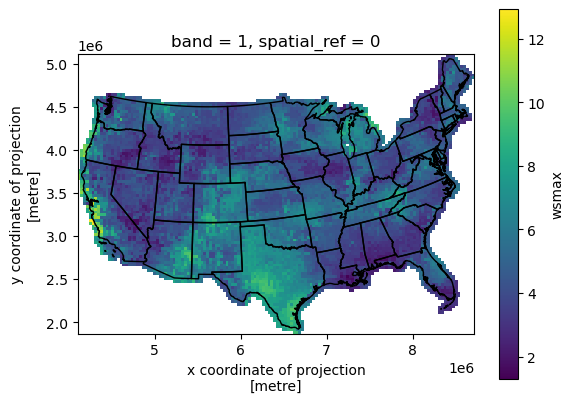

In [13]:
f,ax = plt.subplots()
narr_clipped.plot(ax=ax)
bnd_narr_proj.plot(ax=ax,facecolor='none',edgecolor='black')

## I used QGIS to convert the pixels to polygons and I wrote that out as a shapefile called 'narr_mask.shp'.

In [14]:
narr_grid_df = gpd.read_file(narr_mask_shp, engine='pyogrio', use_arrow=True)

In [15]:
narr_grid_df

,VALUE,geometry
0,1.0,"POLYGON ((-121.57139 49.33451, -121.57139 49.6..."
1,1.0,"POLYGON ((-121.2236 49.33451, -121.2236 49.682..."
2,1.0,"POLYGON ((-120.8758 49.33451, -120.8758 49.682..."
3,1.0,"POLYGON ((-118.78904 49.33451, -118.78904 49.6..."
4,1.0,"POLYGON ((-118.44124 49.33451, -118.44124 49.6..."
...,...,...
7663,1.0,"POLYGON ((-81.57504 24.29332, -81.57504 24.641..."
7664,1.0,"POLYGON ((-81.22725 24.29332, -81.22725 24.641..."
7665,1.0,"POLYGON ((-80.87945 24.29332, -80.87945 24.641..."
7666,1.0,"POLYGON ((-80.53166 24.29332, -80.53166 24.641..."


In [16]:
#f,ax=plt.subplots(figsize=[12,4])
#arr_grid_df.plot(ax=ax,facecolor='none',edgecolor='black')

In [17]:
# Read the LANDFIRE DEM resampled to 240m using Nearest Neighbor
ds_dem = xr.open_mfdataset(conus_dem_file,parallel=True)

In [18]:
#narr_grid_df[7663:7667].plot(facecolor='none')

In [19]:
# Clip to the Montana boundary for display and mapping example
xmin, ymin, xmax, ymax = -116.05114089810897,44.35832834237342,-104.04136319773197,49.00154597004969
narr_grid_df_sub = narr_grid_df.cx[xmin:xmax, ymin:ymax]

In [20]:
# Extract an example polygon for a small point around Missoula, MT
#xmin, ymin, xmax, ymax = -114.4,46.8721,-114.3,46.88
#subpoly = narr_grid_df_sub.cx[xmin:xmax, ymin:ymax]

In [21]:
## Select a subpolygon by an index (802) covers Missoula to test the process
subpoly = narr_grid_df[narr_grid_df.index == 802]
# The grid is in WGS84 Geographic, and a pixel is ~ 0.3 degrees, so let's use that to create a buffer around our pixel
subpolybuf = subpoly.buffer(0.3, join_style='mitre')
print(subpolybuf.bounds)
# Store the bounds of the buffered simulation polygon
subpolybufbnds = subpolybuf.bounds
# Let's reproject this buffered bounding box to UTM (Zone 12N in this example)
subpoly_utm = subpoly.to_crs("EPSG:32612")
# Clip the DEM. Note: Original DEM is in the LANDFIRE project, this just uses a transform from the Geographic BBOX to clip it
clipped_dem = ds_dem.rio.clip_box(minx=subpolybufbnds.minx, miny=subpolybufbnds.miny, maxx=subpolybufbnds.maxx, maxy=subpolybufbnds.maxy, crs="EPSG:4326")
# Note: Need to look up the UTM zones here from the subpoly centroid
# Reproject the DEM to UTM
clipped_dem_utm  = clipped_dem.rio.reproject("EPSG:32612")
#clipped_dem.rio.crs
# Buffer the boundary by 1/2 pixel width
subpolybufbnds = subpoly_utm.buffer(16000, join_style='mitre').bounds
# Clip the DEM to the bounding box
clipped_dem = clipped_dem_utm.rio.clip_box(minx=subpolybufbnds.minx, miny=subpolybufbnds.miny, maxx=subpolybufbnds.maxx,maxy=subpolybufbnds.maxy)


           minx       miny        maxx       maxy
802 -114.567712  46.252159 -113.619917  47.199953


<Axes: >

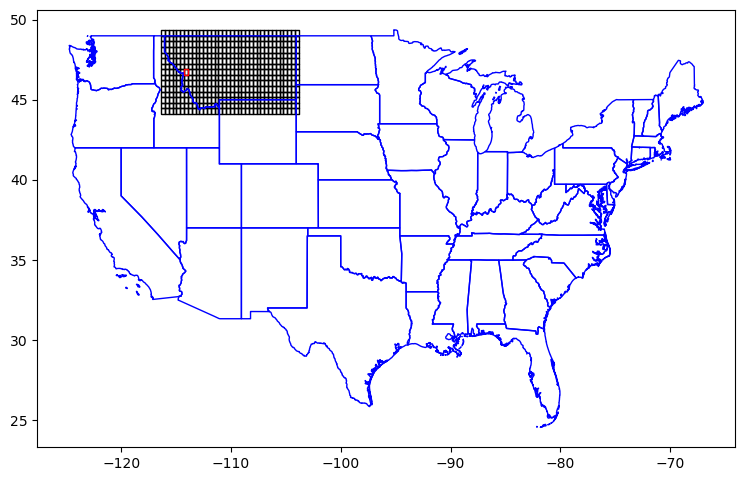

In [22]:
ax = narr_grid_df_sub.plot(facecolor='none',edgecolor='black', figsize=(9, 9))
#cx.add_basemap(ax, crs=narr_grid_df_sub.crs)
bnd.plot(ax=ax,facecolor='none',edgecolor='blue')
subpoly.plot(ax=ax,facecolor='none',edgecolor='red')

Text(0.5, 1.0, 'DEM in native LANDFIRE projection')

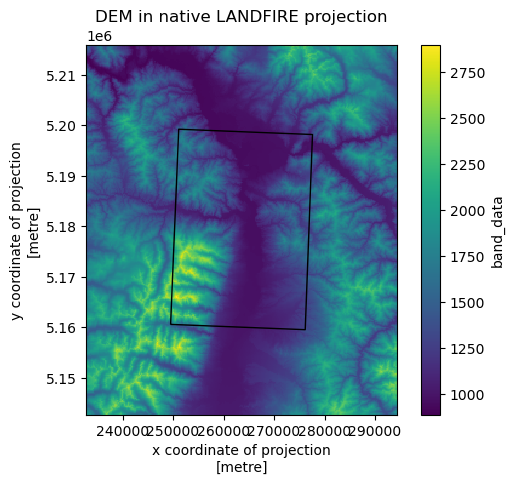

In [23]:
# Plot the DEM in the native LANDFIRE projection
f,ax = plt.subplots()
clipped_dem.band_data[0].plot(ax=ax)
subpoly.to_crs(clipped_dem.rio.crs).plot(ax=ax,facecolor='none', edgecolor='black')
subpolybuf.to_crs(clipped_dem.rio.crs).plot(ax=ax,facecolor='none', edgecolor='black')
ax.set_title("DEM in native LANDFIRE projection")

Text(0.5, 1.0, 'DEM in UTM and the NARR pixel bounding box')

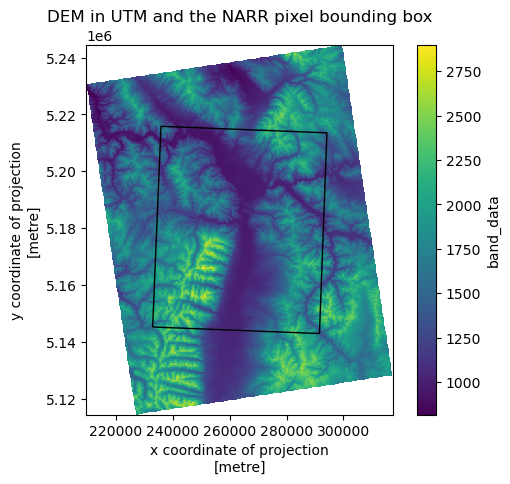

In [24]:
f,ax = plt.subplots()
clipped_dem_utm.band_data[0].plot(ax=ax)
subpoly_utm.buffer(16000, join_style='mitre').plot(ax=ax,facecolor='none',edgecolor='black')
ax.set_title("DEM in UTM and the NARR pixel bounding box")

Text(0.5, 1.0, 'Final DEM for WindNinja in UTM')

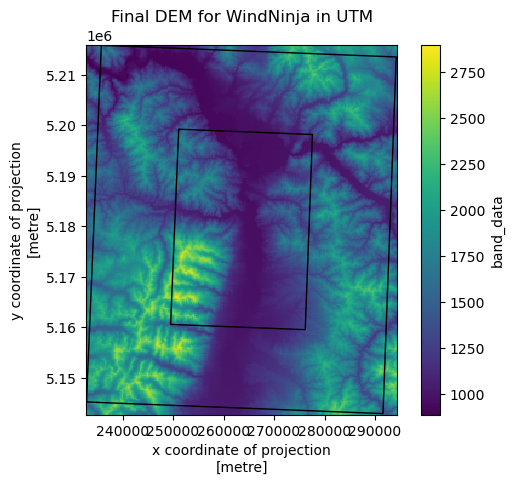

In [25]:
f,ax = plt.subplots()
clipped_dem.band_data[0].plot(ax=ax)
subpoly_utm.plot(ax=ax,facecolor='none')
subpoly_utm.buffer(16000, join_style='mitre').plot(ax=ax,facecolor='none')
ax.set_title("Final DEM for WindNinja in UTM")

## Iterate through the calls to WindNinja and map the calls to an IPyParallel cluster and view
#### On my system, there are some errors looking for GDAL library files but it doesn't seem to impact the simulation outputs

In [26]:
# Grab the index for a polygon
#simnum = int(subpoly.index.values[0])

In [27]:
# Create the cluster outside the loop

In [28]:
def RunWindNinjaNARRCell(narrgridpoly,index,view=None,utm_proj="EPSG:32612"):
 
    # Grab the index this for this polygon
    simnum = index
    simnumstr = str(simnum).zfill(7)
    subpoly = narrgridpoly[narrgridpoly.index == index]
    # The grid is in WGS84 Geographic, and a pixel is ~ 0.3 degrees, so let's use that to create a buffer around our pixel
    subpolybuf = subpoly.buffer(0.3, join_style='mitre')
    print(subpolybuf.bounds)
    # Store the bounds of the buffered simulation polygon
    subpolybufbnds = subpolybuf.bounds
    # Let's reproject this buffered bounding box to UTM (Zone 12N in this example)
    subpoly_utm = subpoly.to_crs(utm_proj)
    # Clip the DEM. Note: Original DEM is in the LANDFIRE project, this just uses a transform from the Geographic BBOX to clip it
    clipped_dem = ds_dem.rio.clip_box(minx=subpolybufbnds.minx, miny=subpolybufbnds.miny, maxx=subpolybufbnds.maxx, maxy=subpolybufbnds.maxy, crs="EPSG:4326")
    # Note: Need to look up the UTM zones here from the subpoly centroid
    # Reproject the DEM to UTM
    clipped_dem_utm  = clipped_dem.rio.reproject(utm_proj)
    #clipped_dem.rio.crs
    # Buffer the boundary by 1/2 pixel width
    subpolybufbnds = subpoly_utm.buffer(16000, join_style='mitre').bounds
    # Clip the DEM to the bounding box
    clipped_dem = clipped_dem_utm.rio.clip_box(minx=subpolybufbnds.minx, miny=subpolybufbnds.miny, maxx=subpolybufbnds.maxx,maxy=subpolybufbnds.maxy)
    
    # Create the output path
    path = f'{basedir}{simnumstr}/'
    dempath = f'{path}{simnumstr}_dem.tif'
          
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    
    if not isExist:
      # Create a new directory because it does not exist 
      os.makedirs(path)
      print("The new data directory is created!")
        
    # Save the DEM to the simulation directory
    clipped_dem.band_data[0].rio.to_raster(dempath)    
    print(dempath)
    arglist = []  # A list of all the individual simulations for WindNinja
    # Create an array of the windspeed ranges
    wdirrange = np.arange(0,360,22.5)
    nproc = 16
    if view == None:
        # Create a cluster with 8 processors
        with ipp.Cluster(n=nproc) as rc:
            # get a view on the cluster
            view = rc.load_balanced_view()    
            view = rc.broadcast_view()
            for wd in wdirrange:
                # Create the input args to to the WindNinja function
                args = {'input_speed' : 5, 'input_direction' : wd, 'elevation_file' : dempath, 'WindNinja_cli':WindNinja_cli}
                # Append the args to a simulation list
                arglist.append(args)
            # submit the tasks to the Cluster
            # Map the list of function inputs to the function calls
            ar = view.map_async(MakeAndCallWindNinjaCLICmd, arglist)
            # wait for the threads to finish
            ar.wait_interactive()
            # retrieve actual results
            #result = syncresult.get()
    else:
        # get a view on the cluster
        view = rc.load_balanced_view()    
        for wd in wdirrange:
            # Create the input args to to the WindNinja function
            args = {'input_speed' : 5, 'input_direction' : wd, 'elevation_file' : dempath, 'WindNinja_cli':WindNinja_cli}
            # Append the args to a simulation list
            arglist.append(args)
        # submit the tasks to the Cluster
        # Map the list of function inputs to the function calls
        ar = view.map_async(MakeAndCallWindNinjaCLICmd, arglist)
        # wait for the threads to finish
        ar.wait_interactive()
        # retrieve actual results
        #result = syncresult.get()
    
        

In [29]:
# Run the WindNinja libraries for 3 cells, these are Missoula and the two cells West
RunWindNinjaNARRCell(narr_grid_df,800)
RunWindNinjaNARRCell(narr_grid_df,801)
RunWindNinjaNARRCell(narr_grid_df,802)

           minx       miny        maxx       maxy
800 -115.263301  46.252159 -114.315506  47.199953
E:/Data/WindNinja/CONUS/0000800/0000800_dem.tif
Starting 16 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/16 [00:00<?, ?engine/s]

MakeAndCallWindNinjaCLICmd:   0%|          | 0/16 [00:00<?, ?tasks/s]

Stopping engine(s): 1728267463
Output for 0:
127: The specified procedure could not be found.


ERROR 1: Can't load requested DLL: C:\Users\mjolly\.conda\envs\geoenv\Library\lib\gdalplugins\gdal_JP2OpenJPEG.dll
127: The specified procedure could not be found.


ERROR 1: Can't load requested DLL: C:\Users\mjolly\.conda\envs\geoenv\Library\lib\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.


ERROR 1: Can't load requested DLL: C:\Users\mjolly\.conda\envs\geoenv\Library\lib\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.


ERROR 1: Can't load requested DLL: C:\Users\mjolly\.conda\envs\geoenv\Library\lib\gdalplugins\gdal_netCDF.dll
127: The specified procedure could not be found.


ERROR 1: Can't load requested DLL: C:\Users\mjolly\.conda\envs\geoenv\Library\lib\gdalplugins\gdal_netCDF.dll
127: The specified procedure could not be found.


ERROR 1: Can't load requested DLL: C:\Users\mjolly\.conda\envs\geoenv\Library\lib\gdalplugins\gdal_P

  0%|          | 0/16 [00:00<?, ?engine/s]

MakeAndCallWindNinjaCLICmd:   0%|          | 0/16 [00:00<?, ?tasks/s]

Stopping engine(s): 1728267518
Output for 0:


ERROR 1: Can't load requested DLL: C:\Users\mjolly\.conda\envs\geoenv\Library\lib\gdalplugins\gdal_JP2OpenJPEG.dll
127: The specified procedure could not be found.


ERROR 1: Can't load requested DLL: C:\Users\mjolly\.conda\envs\geoenv\Library\lib\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.


ERROR 1: Can't load requested DLL: C:\Users\mjolly\.conda\envs\geoenv\Library\lib\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.


ERROR 1: Can't load requested DLL: C:\Users\mjolly\.conda\envs\geoenv\Library\lib\gdalplugins\gdal_netCDF.dll
127: The specified procedure could not be found.


ERROR 1: Can't load requested DLL: C:\Users\mjolly\.conda\envs\geoenv\Library\lib\gdalplugins\gdal_netCDF.dll
127: The specified procedure could not be found.


ERROR 1: Can't load requested DLL: C:\Users\mjolly\.conda\envs\geoenv\Library\lib\gdalplugins\gdal_PDF.dll
127: The specified procedure could not be 

  0%|          | 0/16 [00:00<?, ?engine/s]

MakeAndCallWindNinjaCLICmd:   0%|          | 0/16 [00:00<?, ?tasks/s]

Stopping engine(s): 1728267577
Output for 0:
127: The specified procedure could not be found.


ERROR 1: Can't load requested DLL: C:\Users\mjolly\.conda\envs\geoenv\Library\lib\gdalplugins\gdal_JP2OpenJPEG.dll
127: The specified procedure could not be found.


ERROR 1: Can't load requested DLL: C:\Users\mjolly\.conda\envs\geoenv\Library\lib\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.


ERROR 1: Can't load requested DLL: C:\Users\mjolly\.conda\envs\geoenv\Library\lib\gdalplugins\gdal_KEA.dll
127: The specified procedure could not be found.


ERROR 1: Can't load requested DLL: C:\Users\mjolly\.conda\envs\geoenv\Library\lib\gdalplugins\gdal_netCDF.dll
127: The specified procedure could not be found.


ERROR 1: Can't load requested DLL: C:\Users\mjolly\.conda\envs\geoenv\Library\lib\gdalplugins\gdal_netCDF.dll
127: The specified procedure could not be found.


ERROR 1: Can't load requested DLL: C:\Users\mjolly\.conda\envs\geoenv\Library\lib\gdalplugins\gdal_P

## Let's look at some results from the 3 different NARR grid cells

In [30]:
# Let's load three North Wind scenarios @ 5 mph for adjacent pixels
f = f'{basedir}0000800/0000800_dem_0_5_240m_vel.asc'
ds1 = xr.open_dataset(f)
f = f'{basedir}0000801/0000801_dem_0_5_240m_vel.asc'
ds2 = xr.open_dataset(f)
f = f'{basedir}0000802/0000802_dem_0_5_240m_vel.asc'
ds3 = xr.open_dataset(f)

In [31]:
subpoly1 = narr_grid_df[narr_grid_df.index == 800].to_crs("EPSG:32612")
subpoly2 = narr_grid_df[narr_grid_df.index == 801].to_crs("EPSG:32612")
subpoly3 = narr_grid_df[narr_grid_df.index == 802].to_crs("EPSG:32612")

In [32]:
#ax=subpoly1.plot(facecolor='none',edgecolor='black')
#subpoly1.buffer(60).plot(facecolor='none',edgecolor='black',ax=ax)
#subpoly2.plot(facecolor='none',edgecolor='black',ax=ax)
#subpoly3.plot(facecolor='none',edgecolor='black',ax=ax)

## Clip the larger simulation down to the NARR pixel geometry with a 60m buffer to avoid striping 

In [33]:
# If you don't buffer these images a little before clipping, you get seams of non-data in between. This seems to fix that.
# This clips
ds_clipped1 = ds1.rio.clip(subpoly1.buffer(60).geometry.values,subpoly1.crs, drop=True, invert=False).transpose('band', 'y', 'x')
ds_clipped2 = ds2.rio.clip(subpoly2.buffer(60).geometry.values,subpoly2.crs, drop=True, invert=False).transpose('band', 'y', 'x')
ds_clipped3 = ds3.rio.clip(subpoly3.buffer(60).geometry.values,subpoly3.crs, drop=True, invert=False).transpose('band', 'y', 'x')

In [34]:
# Merge/Mosaic multiple rasters using merge_arrays method of rioxarray
merged_raster = merge_arrays(dataarrays = [ds_clipped1.band_data[0],ds_clipped2.band_data[0],ds_clipped3.band_data[0]], res = (240, 240), crs="EPSG:32612")
 

Text(0.5, 1.0, 'North Wind @ 5mph for 3 NARR cells')

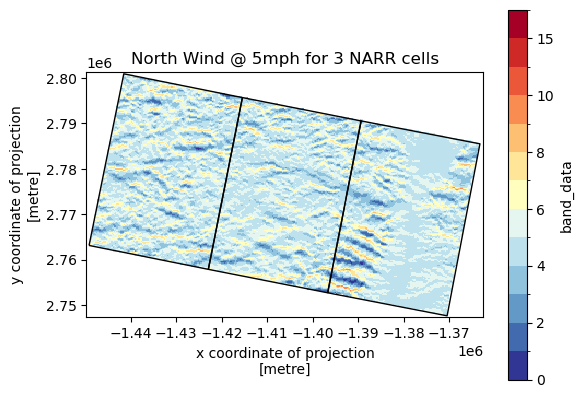

In [35]:
f,ax = plt.subplots()
merged_raster.rio.reproject("EPSG:5070").plot(levels=[0,1,2,3,4,5,6,7,8,9,10,12,15,18],cmap='RdYlBu_r',ax=ax)
subpoly1.to_crs("EPSG:5070").plot(ax=ax,facecolor='none',edgecolor='black')
subpoly2.to_crs("EPSG:5070").plot(ax=ax,facecolor='none',edgecolor='black')
subpoly3.to_crs("EPSG:5070").plot(ax=ax,facecolor='none',edgecolor='black')
ax.set_title('North Wind @ 5mph for 3 NARR cells')

In [36]:
# Create the analysis loop

In [37]:
g.head(10)

NameError: name 'g' is not defined

In [ ]:
g = narr_grid_df
nproc = 16
# Create a cluster with 16 processors
with ipp.Cluster(n=nproc) as rc:
    # Create an array of the windspeed ranges
    wdirrange = np.arange(0,360,22.5)
    view = rc.load_balanced_view()    
    for idx, row in g.head(10).iterrows():
        c = row.geometry.centroid    # Centroid of the NARR pixel polygon
        utm_x, utm_y, band, zone = utm.from_latlon(c.y, c.x) 
        if c.y > 0: # Northern zone
            epsg = 32600 + band
        else:
            epsg = 32700 + band
        #print(idx,c, band, epsg, zone)
        epsgstr = f"EPSG:{epsg}"
        print(idx,epsgstr)
        # get a view on the cluster
           
        RunWindNinjaNARRCell(g,idx,view=view,utm_proj=epsgstr)

        

In [45]:
narr_grid_df.count().values[0]

7668

In [51]:
def RunWindNinjaNARRCellParallel(narr_grid_df):
    narrgridpoly = narr_grid_df
    # Grab the index this for this polygon
    nproc = 80
    g = narrgridpoly
    
    # Create a cluster with 16 processors
    with ipp.Cluster(n=nproc) as rc:
        # Create an array of the windspeed ranges
        wdirrange = np.arange(0,360,22.5)
        #view = rc.load_balanced_view()    
        view = rc.direct_view()
        i = 0
        numblocks = 5
        blocks = 0
        if i < numblocks:
            print(i)
            # Loop through all the NARR Grid Cells
            arglist = []  # A list of all the individual simulations for WindNinja
            for idx, row in g.iterrows():
                c = row.geometry.centroid    # Centroid of the NARR pixel polygon
                # Lookup the UTM grid for the centroid coordinate of the NARR grid cell
                utm_x, utm_y, band, zone = utm.from_latlon(c.y, c.x) 
                if c.y > 0: # Northern zone
                    epsg = 32600 + band
                else:
                    epsg = 32700 + band
    
                # Create the EPSG string
                utm_proj = epsgstr = f"EPSG:{epsg}"
                               
                #RunWindNinjaNARRCell(g,idx,view=view,utm_proj=epsgstr)
                
                simnum = idx
                simnumstr = str(simnum).zfill(7)
                subpoly = narrgridpoly[narrgridpoly.index == idx]
                # The grid is in WGS84 Geographic, and a pixel is ~ 0.3 degrees, so let's use that to create a buffer around our pixel
                subpolybuf = subpoly.buffer(0.3, join_style='mitre')
                print(subpolybuf.bounds)
                # Store the bounds of the buffered simulation polygon
                subpolybufbnds = subpolybuf.bounds
                # Let's reproject this buffered bounding box to UTM (Zone 12N in this example)
                subpoly_utm = subpoly.to_crs(utm_proj)
                # Clip the DEM. Note: Original DEM is in the LANDFIRE project, this just uses a transform from the Geographic BBOX to clip it
                clipped_dem = ds_dem.rio.clip_box(minx=subpolybufbnds.minx, miny=subpolybufbnds.miny, maxx=subpolybufbnds.maxx, maxy=subpolybufbnds.maxy, crs="EPSG:4326")
            
                # Reproject the DEM to UTM
                clipped_dem_utm  = clipped_dem.rio.reproject(utm_proj)
                #clipped_dem.rio.crs
                # Buffer the boundary by 1/2 pixel width
                subpolybufbnds = subpoly_utm.buffer(16000, join_style='mitre').bounds
                # Clip the DEM to the bounding box
                clipped_dem = clipped_dem_utm.rio.clip_box(minx=subpolybufbnds.minx, miny=subpolybufbnds.miny, maxx=subpolybufbnds.maxx,maxy=subpolybufbnds.maxy)
                
                # Create the output path
                path = f'{basedir}{simnumstr}/'
                dempath = f'{path}{simnumstr}_dem.tif'
                      
                # Check whether the specified path exists or not
                isExist = os.path.exists(path)
                
                if not isExist:
                  # Create a new directory because it does not exist 
                  os.makedirs(path)
                  print("The new data directory is created!")
                    
                # Save the DEM to the simulation directory
                clipped_dem.band_data[0].rio.to_raster(dempath)    
                print(dempath)
                                                 
                for wd in wdirrange:
                    # Create the input args to to the WindNinja function
                    args = {'input_speed' : 5, 'input_direction' : wd, 'elevation_file' : dempath, 'WindNinja_cli':WindNinja_cli}
                    # Append the args to a simulation list
                    arglist.append(args)
                
                print(i,blocks)                        
                if (i == numblocks) or (i == g.count().values[0] - 1):
                    blocks+=1
                    print("Running block: ",blocks)
                    # submit the tasks to the Cluster
                    # Map the list of function inputs to the function calls
                    ar = view.map(MakeAndCallWindNinjaCLICmd, arglist)
                    # wait for the threads to finish
                    ar.wait_interactive()
                    # retrieve actual results
                    result = ar.get()
                    i = 0  # Start the block counter over
                    arglist = []
                else:
                    i+=1
                    
            
        

In [52]:
narr_grid_df.head(20).copy()

,VALUE,geometry
0,1.0,"POLYGON ((-121.57139 49.33451, -121.57139 49.6..."
1,1.0,"POLYGON ((-121.2236 49.33451, -121.2236 49.682..."
2,1.0,"POLYGON ((-120.8758 49.33451, -120.8758 49.682..."
3,1.0,"POLYGON ((-118.78904 49.33451, -118.78904 49.6..."
4,1.0,"POLYGON ((-118.44124 49.33451, -118.44124 49.6..."
5,1.0,"POLYGON ((-118.09345 49.33451, -118.09345 49.6..."
6,1.0,"POLYGON ((-115.31109 49.33451, -115.31109 49.6..."
7,1.0,"POLYGON ((-114.9633 49.33451, -114.9633 49.682..."
8,1.0,"POLYGON ((-109.39859 49.33451, -109.39859 49.6..."
9,1.0,"POLYGON ((-109.0508 49.33451, -109.0508 49.682..."


In [ ]:
RunWindNinjaNARRCellParallel(narr_grid_df.head(20).copy())

Starting 80 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>
